1 Prepração do notebook
2 Obtenção dos dados, tratamento e geração de Data Frames

* Dados sobre Covid
    * Obtenção de dados do COVID19 e geração do Data Frame df_covid19_br
    * Geração do df_covid19_br_para_shapefile com tratamento dos dados
    * Geração do Geo Data Frames gdf_covid19_br, com os casos para o Brasil, e gdf_covid19_pr, com os casos do Paraná
* Obtenção dos Demais dados
* nível de hierarquia urbana
* população
* mobilidade pendular
* níveis de exportação
* pib percapita
* número de pessoas com renda elevada (a definir o critério)
* tentar identificar uma forma de criar uma base que se atualize dinamicamente e identifique avizinhamento de municípios 0 e 1 

3 Análise Exploratória Correlações

* Gerar painel de estatística descritiva

* Gerar gráficos de distribuição
* Fazer matriz de correlações

4 Modelização

# Obtenção, tratamento e Análise Exploratória dos dados sobre COVID-19 no Brasil

## Preparação do Notebook

* Importação das principais bibliotecas
* Configuração das operações por default (estilos e tamanhos de gráficos)
* Referenciamento das subpastas do projeto

In [47]:
# importação de bibliotecas básicas

import pandas as pd # Biblioteca para operação avançada com dados tabulares de diversos tipos
import numpy as np # Biblioteca para operação com vetores de auto desempenho e um tipo por vez
from matplotlib import use as mpl_use # Função Matplotlib que estabelece backend e precisa ser chamda antes do plt
mpl_use('nbagg') # uso do backend "nbagg" para os gráficos terem paineis interativos
import matplotlib.pyplot as plt # Biblioteca para geração de gráficos de menor nível de abstração
import seaborn as sns # Biblioteca baseada em matplotlib para geração de gráficos e estilização, com maior nível de abstração
import geopandas as gpd # Biblioteca de análise geográfica
import descartes # Dependência do Geopandas para poder gerar mapas
import matplotlib 
import os

In [48]:
# configurações das operações por default

# Configuração de DataFrame Pandas para formato numérico com duas casas decimais quando a coluna for float
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Apresentação dos gráficos no interior das células
%matplotlib inline 
plt.style.use('ggplot') # Apresentação dos gráficos

# Códigos abaixo são configurações que deixo por opção, caso se tornem úteis em alguma operação
# Configuração das Células para que apresentam múltiplos resultados em vez de apenas o último 
# InteractiveShell.ast_node_interactivity = "all"
# sns.set() # Configuração de Gráficos para padrão de formatação básica da biblioteca Seaborn

In [49]:
# referenciamento das subpastas

diretorio_economia = os.path.join(os.getcwd(),'base_de_dados','economia')
diretorio_casos = os.path.join(os.getcwd(),'base_de_dados','boletins_de_casos')
diretorio_hierarquia_urbana = os.path.join(os.getcwd(),'base_de_dados','hierarquia_urbana')
diretorio_infra_atendimento = os.path.join(os.getcwd(),'base_de_dados','infraestrutura_atendimento')
diretorio_populacao = os.path.join(os.getcwd(),'base_de_dados','populacao')
diretorio_transporte_rodoviario = os.path.join(os.getcwd(),'base_de_dados','transporte_rodoviario')
diretorio_turismo = os.path.join(os.getcwd(),'base_de_dados','turismo')
diretorio_estrutura_territorial = os.path.join(os.getcwd(),'base_de_dados','estrutura_territorial')


## Importação e Tratamento Preliminar dos Dados

* Verificação da Estrutura dos dados
* Observação da pertinência dos tipos
* Identificação e tratamento dos dados nulos
* Codificação de variáveis categóricas
* Separação dos batches
    * Estratificado
    * Não Estratificado
* Criar versão com regularização de escala

São criados três DataFrames

* Dados de Notificações nos municípios brasileiros
    * df_covid_19_br - dados de notificações nos municípios brasileiros
    * df_casos_sem_referencia_municipal
    * df_covid_19_br_to_shape - dados de notificações readequados para importação em ambiente de Sistemas de Informações Geográficas 
    * df_data_primeiro_caso - dados dos da data do primeiro caso

### Dados de notificações nos municípios brasileiros
* Abaixo se encontra uma função colect_cases, que obtem os dados sobre COVID-19 compilados dos boletins e disponível em "https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv"
    * Os dados são salvos em Pandas Data Frame
    * Os nomes das colunas são corrigidos
    * As duplicidades são eliminadas, pela retirada de várias linhas com totais

Observações: É conveniente que, no futuro, a função tenha um tratamento para que as datas não estejam em formato texto

In [50]:
def colect_cases(output=None, output_format='csv', correct_columns=True, correct_rows=True):
    # Retrieves the notified cases in Brazilian boletins found in
    # https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv
    # correct_columns -> whether or not to rearrange the columns and rename them
    # Correct_rows -> whether or not to remove the total cases by date, which would duplicate the values per day
    # name_csv -> string withe name of the csv file to save the content of the Data Frame. If name_csv equals to None, no file is saved

    # loads the CSV data into df_cases
    df_cases = pd.read_csv(
        'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv',
        parse_dates=True,
        infer_datetime_format=True)

    # if correct_columns == True, it rearranges the columns orders and renames them
    if correct_columns == True:
        df_cases = df_cases[['ibgeID', 'city', 'state', 'date', 'newCases', 'totalCases']].rename(
            columns={'ibgeID': 'cod_mun', 'city': 'municipio', 'state': 'estado', 'date': 'data', 'newCases': 'novos_casos', 'totalCases': 'casos_total'})

    # if correct_rows == True, it removes the rows that show the total cases by date, which would duplicate the values per day
    if correct_rows == True:
        filter_cases_total = df_cases.loc[df_cases.estado == 'TOTAL']
        df_cases.drop(filter_cases_total.index, axis=0, inplace=True)

    # removes the state name in the municipality column
    df_cases.municipio = df_cases.municipio.apply(
        lambda a_corrigir: a_corrigir.split('/')[0])

    # if name_csv contains the name of a csv file, a file will be created in the current directory
    # or in the specified directory
    if output != None:
        if output_format == 'csv':
            df_cases.to_csv(output, encoding='utf-16')
        if output_format == 'excel':
            df_cases.to_excel(output, encoding='utf-16')

    return df_cases

Importação, observação e tratamento preliminar dos dados

* Criação do Data Frame df_covid_19_br
* observação preliminar dos dados
* identificação de sua estrutura de linhas e colunas

**Data Frame df_covid_19_br**

In [51]:
df_covid_19_br = colect_cases()
df_covid_19_br

,cod_mun,municipio,estado,data,novos_casos,casos_total
0,3550308,São Paulo,SP,2020-02-25,1,1
2,3550308,São Paulo,SP,2020-02-29,1,2
4,3550308,São Paulo,SP,2020-03-04,1,3
6,3550308,São Paulo,SP,2020-03-05,3,6
7,3300407,Barra Mansa,RJ,2020-03-05,1,1
...,...,...,...,...,...,...
6104,3303708,Paraíba do Sul,RJ,2020-04-05,0,2
6105,3302858,Mesquita,RJ,2020-04-05,0,1
6106,3303401,Nova Friburgo,RJ,2020-04-05,0,1
6107,42,NÃO ESPECIFICADA,SC,2020-04-05,0,23


**Informações da estrutura do Data Frame df_covid_19_br**<br>
O Data Frame df_covid_19_br conta com {{len(df_covid_19_br.index)}} linhas e {{len(df_covid_19_br.columns)}} colunas.
A estrutura do df_covid_19_br não é adequada para importação em formato shapefile, necessário para geração de cartogramas 

In [52]:
df_covid_19_br.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6075 entries, 0 to 6108
Data columns (total 6 columns):
cod_mun        6075 non-null int64
municipio      6075 non-null object
estado         6075 non-null object
data           6075 non-null object
novos_casos    6075 non-null int64
casos_total    6075 non-null int64
dtypes: int64(3), object(3)
memory usage: 332.2+ KB


**verificação de dados faltantes**

O heatmap abaixo e a série de dados adiante mostram que não existe célula em branco no Data Frame df_covid_19_br

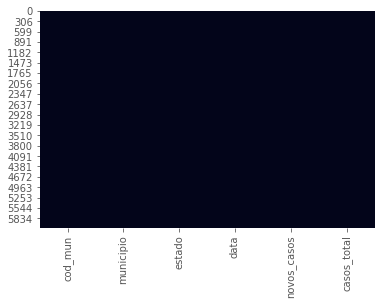

In [53]:
#gráfico heatmap para identificação do padrão de distribuição dos valores nulos no Data Frame
sns.heatmap(df_covid_19_br.isnull(), cbar=False); 

In [54]:
df_covid_19_br.isnull().sum()

cod_mun        0
municipio      0
estado         0
data           0
novos_casos    0
casos_total    0
dtype: int64

**Dados sem associação com municípios**<br>
Algumas linhas contam o número de casos, mas sem associar a seus municípios, colocando-os como Fora do Estado, Estrangeiro e No-INFO

In [55]:
filter_len_cod_mun = df_covid_19_br.cod_mun.astype('str').str.len() == 2
filter_last_date = df_covid_19_br.data == df_covid_19_br.data.max()

df_casos_sem_referencia_municipal = df_covid_19_br[filter_len_cod_mun]

df_casos_sem_referencia_municipal.head()

,cod_mun,municipio,estado,data,novos_casos,casos_total
123,26,ESTRANGEIRO,PE,2020-03-14,1,1
182,26,ESTRANGEIRO,PE,2020-03-15,0,1
202,26,ESTRANGEIRO,PE,2020-03-16,2,3
277,26,ESTRANGEIRO,PE,2020-03-17,0,3
329,42,ESTRANGEIRO,SC,2020-03-18,2,2


In [56]:
df_casos_sem_referencia_municipal.municipio.value_counts(),

(FORA DO ESTADO      85
 NÃO ESPECIFICADA    79
 ESTRANGEIRO         55
 Name: municipio, dtype: int64,)

In [57]:
df_casos_sem_referencia_municipal[['municipio','casos_total']].groupby(by='municipio', axis=0).sum()

,casos_total
municipio,
ESTRANGEIRO,492
FORA DO ESTADO,498
NÃO ESPECIFICADA,1918


**data frame dos primeiros casos**

In [58]:
#geração do Data Frame com a data do primeiro caso por municípios

dic_data_inicial = {}
cod_municipios = df_covid_19_br[~filter_len_cod_mun].cod_mun.unique()
for codigo in cod_municipios:
    data_inicial = df_covid_19_br[df_covid_19_br.cod_mun == codigo]['data'].min()
    dic_data_inicial[codigo] = data_inicial

df_data_primeiro_caso = pd.DataFrame(data=dic_data_inicial.values(), index=dic_data_inicial.keys(), columns = ['data_primeiro_caso'])

df_data_primeiro_caso

,data_primeiro_caso
3550308,2020-02-25
3300407,2020-03-05
3205200,2020-03-05
2910800,2020-03-06
3304557,2020-03-07
...,...
2112209,2020-04-04
1600501,2020-04-04
3303708,2020-04-04
3302858,2020-04-04


**Geração do Shapefile com os dados de CoronaVirus**

In [59]:
def preparing_shape_data(df):
    
    
    # retira os casos do estado que não estão associados a municipios
    filter_len_cod_mun = df.cod_mun.astype('str').str.len() == 2 #filtro de cod_mun de apenas dois caracteres
    df = df[~filter_len_cod_mun] # Retira do Data Frame df as linhas em que cod_mun tem apenas dois caracteres 
    
    # pivoteia o df, com cod_mun na linha, datas nas colunas e casos totais como valores
    df = df[['cod_mun',
              'data',
              'casos_total']].pivot_table(index='cod_mun', columns='data', values='casos_total')
    
    # corrige o nome das colunas
    list_new_column_names = []
    for old_name in df.columns:
        new_name = 'dia' + old_name.split('-')[2]+ old_name.split('-')[1]
        list_new_column_names.append(new_name)
    df.columns = list_new_column_names
    
    
    
    #list_new_column_names = []
    #for old_column_name in df.columns:
    #    new_name = 'dia' + old_column_name.split('-')[1] + old_column_name.split('-')[0]
    #    list_new_column_names.append(new_name)
    #df.columns = list_new_column_names
    
    # insere 0 nos casos em que o valores são nulos
    df.fillna(0, inplace=True)
    
    # transforma os dados em integers
    
    df = df.astype('int32')
    
    
    return df

In [60]:
# Gera o Data Frame com os dados de COVID no formato adequado para importação em Geo Data Frame
df_covid_19_br_to_shape = preparing_shape_data(df_covid_19_br)

In [61]:
# visualização do Data Frame com os dados para importação em Geo Data Frame
df_covid_19_br_to_shape

,dia2502,dia2902,dia0403,dia0503,dia0603,dia0703,dia0803,dia0903,dia1003,dia1103,...,dia2703,dia2803,dia2903,dia3003,dia3103,dia0104,dia0204,dia0304,dia0404,dia0504
cod_mun,,,,,,,,,,,,,,,,,,,,,
1100114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1
1100122,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1100205,0,0,0,0,0,0,0,0,0,0,...,5,5,5,6,7,7,8,8,9,9
1200013,0,0,0,0,0,0,0,0,0,0,...,0,0,2,7,7,8,8,9,9,9
1200401,0,0,0,0,0,0,0,0,0,0,...,25,25,31,34,34,34,36,36,36,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
5220603,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
5221403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1


In [62]:
# Cria o Geo Data Frame com base na shapefile de todos os municipios do Brasil
gdf_municipios_br = gpd.read_file('BRMUE250GC_SIR.shp', encoding='utf-8')
gdf_municipios_br

,NM_MUNICIP,CD_GEOCMU,geometry
0,CACHOEIRA DO PIRIÁ,1501956,"POLYGON ((-46.31955 -1.75518, -46.31990 -1.755..."
1,SÃO JOSÉ DOS BASÍLIOS,2111250,"POLYGON ((-44.63409 -5.03498, -44.63407 -5.034..."
2,APARECIDA DO RIO DOCE,5201454,"POLYGON ((-51.14230 -18.29672, -51.14236 -18.2..."
3,ARENÓPOLIS,5202353,"POLYGON ((-51.69953 -16.23270, -51.69957 -16.2..."
4,CURUÁ,1502855,"POLYGON ((-55.17193 -1.83331, -55.16647 -1.731..."
...,...,...,...
5567,PARAGUAÇU PAULISTA,3535507,"POLYGON ((-50.69420 -22.39885, -50.69410 -22.3..."
5568,ÁGUA LIMPA,5200209,"POLYGON ((-48.86197 -17.98972, -48.86111 -17.9..."
5569,SANTA CRUZ DO SUL,4316808,"POLYGON ((-52.46848 -29.70647, -52.46847 -29.7..."
5570,SAUDADES,4217303,"POLYGON ((-53.10221 -26.93414, -53.10236 -26.9..."


In [63]:
# Verifica a estrutura do Geo Data Frame
gdf_municipios_br.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
NM_MUNICIP    5572 non-null object
CD_GEOCMU     5572 non-null object
geometry      5572 non-null geometry
dtypes: geometry(1), object(2)
memory usage: 130.7+ KB


In [64]:
# Renomeia as colunas do Geo Data Frame
gdf_municipios_br.columns = ['municipio', 'cod_mun', 'geometry']

In [65]:
# Altera o tipo da coluna cod_mun no Geo Data Frame para integer
gdf_municipios_br.cod_mun  = pd.to_numeric(gdf_municipios_br.cod_mun, downcast='integer')

In [66]:
# Expande o Data Frame df_covid_19_br_to_shape para que tenha os mesmos indexes encontrados no Geo Data Frame

df_covid_19_br_to_shape = df_covid_19_br_to_shape.reindex(gdf_municipios_br.cod_mun.values)

In [67]:
# Faz a junção entre Geo Data Frame e o Data Frame 

gdf_municipios_br = gdf_municipios_br.merge(df_covid_19_br_to_shape, on='cod_mun')

In [68]:
gdf_municipios_br.iloc[:, 3:] = gdf_municipios_br.iloc[:, 3:].fillna(0)

In [69]:
gdf_municipios_br.nlargest(n=10, columns='dia3003')

,municipio,cod_mun,geometry,dia2502,dia2902,dia0403,dia0503,dia0603,dia0703,dia0803,...,dia2703,dia2803,dia2903,dia3003,dia3103,dia0104,dia0204,dia0304,dia0404,dia0504
2537,SÃO PAULO,3550308,"POLYGON ((-46.46934 -23.48106, -46.46885 -23.4...",1.0,2.0,3.0,6.0,10.0,13.0,15.0,...,1044.0,1044.0,1044.0,1233.0,1885.0,2418.0,2815.0,3202.0,3202.0,3202.0
1067,RIO DE JANEIRO,3304557,"MULTIPOLYGON (((-43.70288 -22.98523, -43.70286...",0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,431.0,489.0,516.0,553.0,586.0,697.0,798.0,867.0,982.0,982.0
440,FORTALEZA,2304400,"POLYGON ((-38.56771 -3.84953, -38.57672 -3.845...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,268.0,304.0,338.0,353.0,371.0,413.0,526.0,600.0,681.0,704.0
2557,BRASÍLIA,5300108,"POLYGON ((-47.81455 -16.04995, -47.81478 -16.0...",0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,242.0,260.0,298.0,312.0,333.0,355.0,400.0,425.0,456.0,456.0
3566,BELO HORIZONTE,3106200,"POLYGON ((-43.92060 -19.80202, -43.92021 -19.8...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,123.0,132.0,146.0,163.0,163.0,188.0,210.0,225.0,237.0,237.0
1072,PORTO ALEGRE,4314902,"MULTIPOLYGON (((-51.28678 -30.12193, -51.28710...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,107.0,107.0,143.0,143.0,190.0,190.0,232.0,233.0,241.0,241.0
2346,MANAUS,1302603,"POLYGON ((-59.92021 -2.61052, -59.91470 -2.616...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,75.0,105.0,131.0,140.0,159.0,179.0,205.0,232.0,283.0,283.0
3087,SALVADOR,2927408,"POLYGON ((-38.39181 -12.84328, -38.39180 -12.8...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,78.0,81.0,103.0,117.0,132.0,153.0,167.0,183.0,215.0,215.0
4876,CURITIBA,4106902,"POLYGON ((-49.24591 -25.34942, -49.24536 -25.3...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,71.0,73.0,73.0,76.0,87.0,98.0,99.0,114.0,114.0,114.0
1713,RECIFE,2611606,"POLYGON ((-34.91029 -7.95375, -34.91285 -7.969...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.0,46.0,49.0,53.0,58.0,65.0,74.0,92.0,119.0,119.0


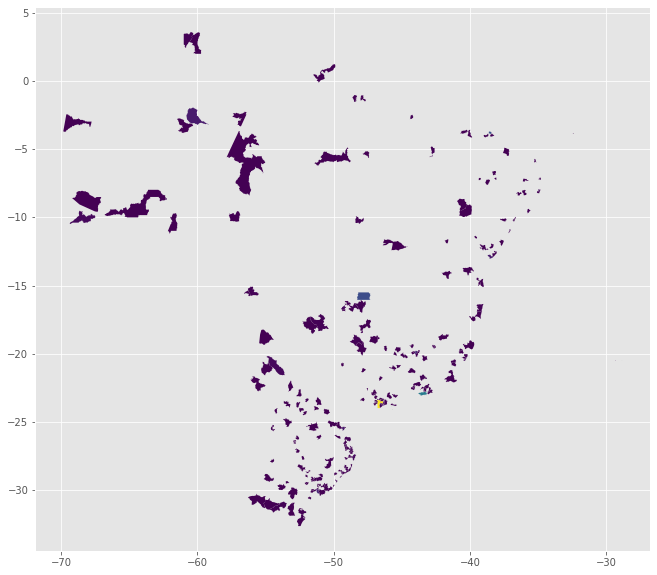

In [70]:
gdf_municipios_br[gdf_municipios_br['dia2703'] != 0].plot(column='dia2703', figsize=(15, 10))

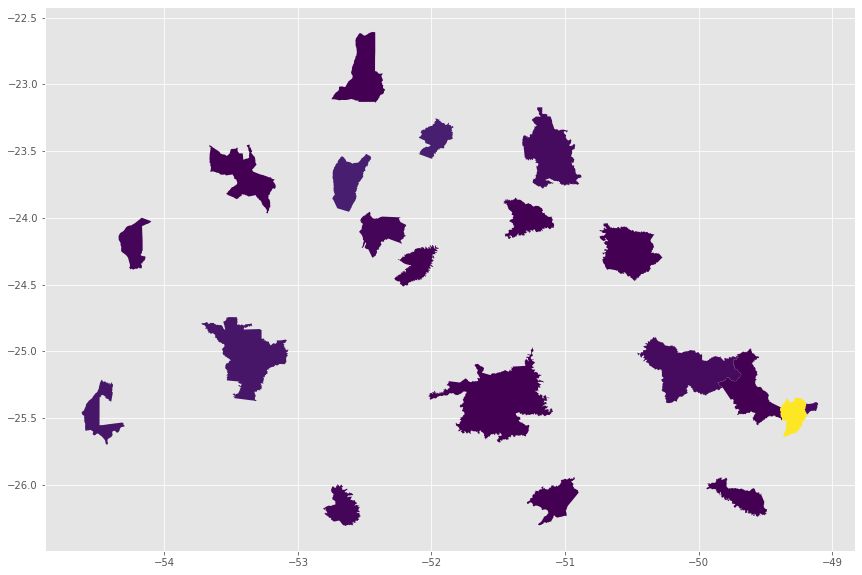

In [71]:
filtro_parana = (gdf_municipios_br.cod_mun.astype('str').str[0:2] == '41') & (gdf_municipios_br['dia2703'] != 0)
gdf_municipios_br[filtro_parana].plot(column='dia2703', figsize=(15, 10))

### Dados de Fatores Geográficos

In [72]:
df_fatores_geograficos = pd.read_csv('base_compilada_de_fatores_geograficos.csv', delimiter=';', encoding='utf-8')

In [73]:
df_fatores_geograficos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 14 columns):
cod_mun                 5570 non-null int64
UF                      5570 non-null object
Município               5570 non-null object
pop2019                 5570 non-null int64
pib2017milreais         5570 non-null int64
export_fob_2019         5570 non-null int64
import_fob_2019         5570 non-null int64
pip_per_capita17        5570 non-null int64
hierarquia_urbana07     5570 non-null object
hierarquia              5570 non-null int64
voos_dom                5570 non-null int64
voos_int                5570 non-null int64
indice_proximidade      5570 non-null object
indice_intermediacao    5570 non-null object
dtypes: int64(9), object(5)
memory usage: 609.3+ KB


In [74]:
df_fatores_geograficos.describe()

,cod_mun,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia,voos_dom,voos_int
count,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5.570000e+03,5570.000000,5570.000000,5570.000000,5570.000000
mean,3.253591e+06,3.772839e+04,1.181924e+06,4.040838e+07,3.183982e+07,2199.074686,1.715440,12.081688,1.002693
std,9.849103e+05,2.214581e+05,1.162173e+07,3.099210e+08,3.122626e+08,2094.632926,1.921235,254.325169,40.658039
min,1.100015e+06,7.810000e+02,1.299300e+04,0.000000e+00,0.000000e+00,329.000000,1.000000,0.000000,0.000000
25%,2.512126e+06,5.446500e+03,7.910150e+04,0.000000e+00,0.000000e+00,949.000000,1.000000,0.000000,0.000000
50%,3.146280e+06,1.163100e+04,1.766215e+05,0.000000e+00,0.000000e+00,1660.000000,1.000000,0.000000,0.000000
75%,4.119190e+06,2.549050e+04,4.702212e+05,1.264064e+06,1.648922e+05,2705.000000,1.000000,0.000000,0.000000
max,5.300108e+06,1.225202e+07,6.992884e+08,1.130984e+10,1.012971e+10,34485.000000,11.000000,15172.000000,2791.000000


In [75]:
df_fatores_geograficos.set_index('cod_mun', inplace=True)

**arranjos populacionais**

In [76]:
df_arranjos_populacionais = pd.read_csv('arranjo_populacional.csv', sep=';', decimal=',')

In [77]:
# insere a coluna peso
df_arranjos_populacionais['peso_integracao_interna'] = 0

# calcula o peso populacional de cada municipio no conjunto
for arranjo in df_arranjos_populacionais.arranjo_populacional.unique():
    filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == arranjo
    df_arranjos_populacionais.loc[:,'peso_integracao_interna'].loc[filtro_arranjo_pop] = df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019 / df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019.sum();

C:\Users\Acer A315\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [78]:
# insere a coluna peso
df_arranjos_populacionais['peso_integracao_geral'] = 0

# calcula o peso populacional de cada municipio no conjunto
for arranjo in df_arranjos_populacionais.arranjo_populacional.unique():
    filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == arranjo
    df_arranjos_populacionais.loc[:,'peso_integracao_geral'].loc[filtro_arranjo_pop] = df_arranjos_populacionais.loc[filtro_arranjo_pop].loc[:,'pessoas_em_pendularidade_trabalho'].sum() / df_arranjos_populacionais.loc[:,'pessoas_em_pendularidade_trabalho'].sum();

In [79]:
df_fatores_geograficos = df_fatores_geograficos.join(df_arranjos_populacionais.loc[:,['cod_mun', 'peso_integracao_interna', 'peso_integracao_geral']], on='cod_mun')

In [80]:
df_fatores_geograficos

,UF,Município,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,voos_dom,voos_int,indice_proximidade,indice_intermediacao,cod_mun,peso_integracao_interna,peso_integracao_geral
cod_mun,,,,,,,,,,,,,,,,
1100015,RO,Alta Floresta D'Oeste,22945,498864,198695,13294,1961,Centro Local,1,0,0,"0,30416971",0,NaN,NaN,NaN
1100023,RO,Ariquemes,107863,2296074,38002769,738809,2139,Centro Subregional B,4,0,0,"0,4171477","0,00720614",NaN,NaN,NaN
1100031,RO,Cabixi,5312,138894,137660,0,2232,Centro Local,1,0,0,"0,23445949",0,NaN,NaN,NaN
1100049,RO,Cacoal,85359,2127523,20514957,53854,2404,Centro Subregional B,4,25,0,"0,40565826","0,00138341",NaN,NaN,NaN
1100056,RO,Cerejeiras,16323,448524,97838806,59259,2501,Centro de Zona B,2,0,0,"0,3062666","0,00073794",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222005,GO,Vianópolis,13863,395787,0,0,2894,Centro Local,1,0,0,"0,33807385","0,00000349",NaN,NaN,NaN
5222054,GO,Vicentinópolis,8743,350765,6518444,0,4177,Centro Local,1,0,0,"0,33058859","0,00000455",NaN,NaN,NaN
5222203,GO,Vila Boa,6171,137500,0,0,2399,Centro Local,1,0,0,"0,29688869","0,00000028",NaN,NaN,NaN


### Integração dos Dados

In [81]:
df_fatores_geograficos = df_fatores_geograficos.join(df_covid_19_br_to_shape)

In [82]:
df_fatores_geograficos.iloc[:, 10:] = df_fatores_geograficos.iloc[:, 10:].fillna(0)

In [83]:
df_fatores_geograficos = df_fatores_geograficos.join(df_data_primeiro_caso)

In [84]:
df_fatores_geograficos.data_primeiro_caso = pd.to_datetime(df_fatores_geograficos.data_primeiro_caso)

In [85]:
df_fatores_geograficos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5570 entries, 1100015 to 5300108
Data columns (total 52 columns):
UF                         5570 non-null object
Município                  5570 non-null object
pop2019                    5570 non-null int64
pib2017milreais            5570 non-null int64
export_fob_2019            5570 non-null int64
import_fob_2019            5570 non-null int64
pip_per_capita17           5570 non-null int64
hierarquia_urbana07        5570 non-null object
hierarquia                 5570 non-null int64
voos_dom                   5570 non-null int64
voos_int                   5570 non-null int64
indice_proximidade         5570 non-null object
indice_intermediacao       5570 non-null object
cod_mun                    5570 non-null float64
peso_integracao_interna    5570 non-null float64
peso_integracao_geral      5570 non-null float64
dia2502                    5570 non-null float64
dia2902                    5570 non-null float64
dia0403                

In [86]:
df_fatores_geograficos['data_padrao'] = pd.to_datetime('2020-02-24')

df_fatores_geograficos['dias_contaminação_referencia'] = df_fatores_geograficos['data_primeiro_caso'].sub(df_fatores_geograficos['data_padrao'], axis=0)


df_fatores_geograficos['dias_contaminação_referencia'] = df_fatores_geograficos['dias_contaminação_referencia'] / np.timedelta64(1, 'D')


In [87]:
df_fatores_geograficos.nlargest(n=10, columns='dias_contaminação_referencia')

,UF,Município,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,voos_dom,...,dia3003,dia3103,dia0104,dia0204,dia0304,dia0404,dia0504,data_primeiro_caso,data_padrao,dias_contaminação_referencia
cod_mun,,,,,,,,,,,,,,,,,,,,,
1600501,AP,Oiapoque,27270,394500,0,0,1546,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2020-04-04,2020-02-24,40.0
1707009,TO,Dianópolis,22139,299061,1216,0,1376,Centro de Zona A,3,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2020-04-04,2020-02-24,40.0
2107506,MA,Paço do Lumiar,122197,869375,0,64085,710,Capital Regional A,8,0,...,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2020-04-04,2020-02-24,40.0
2111201,MA,São José de Ribamar,177687,1996204,648965,21370,1132,Capital Regional A,8,0,...,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2020-04-04,2020-02-24,40.0
2112209,MA,Timon,169107,1802654,6312724,160717,1075,Capital Regional A,8,0,...,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2020-04-04,2020-02-24,40.0
2300101,CE,Abaiara,11737,92945,0,0,801,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2020-04-04,2020-02-24,40.0
2305233,CE,Horizonte,67337,1596807,6813459,35414663,2422,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2020-04-04,2020-02-24,40.0
2306306,CE,Itapajé,52675,549959,9704612,158228,1059,Centro de Zona B,2,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2020-04-04,2020-02-24,40.0
2900355,BA,Adustina,17040,120424,0,0,694,Centro Local,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2020-04-04,2020-02-24,40.0


In [88]:
df_fatores_geograficos.to_csv('fatores_para_k_means.csv', sep=';', decimal=',', encoding='utf-16')

In [ ]:
df_fatores_geograficos.nlargest(n=10, columns='dias_contaminação_referencia')

In [ ]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

In [ ]:
df_fatores_geograficos.to_csv('fatores_total.csv', sep=';', decimal=',', encoding='utf-16')

In [ ]:
df_arranjos_populacionais.loc[:,['cod_mun', 'peso_integracao_interna', 'peso_integracao_geral']]

In [ ]:
df_arranjos_populacionais.loc[:,'peso_integracao_geral'].sum()

In [ ]:
next(iter_test)[1].values[0]

In [ ]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == next(iter_test)[1].values[0]
df_arranjos_populacionais[filtro_arranjo_pop]

In [ ]:
df_arranjos_populacionais['peso'] = 0

In [ ]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == 'São José do Rio Preto/SP'
df_arranjos_populacionais.loc[:,'peso'].sum()

In [ ]:
filtro_arranjo_pop = df_arranjos_populacionais.arranjo_populacional == 'Antônio Prado/RS'

#df_arranjos_populacionais.loc[filtro_arranjo_pop].loc[:,'peso'] = 

df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019 / df_arranjos_populacionais.loc[filtro_arranjo_pop].pop_2019.sum()


#df_arranjos_populacionais[filtro_arranjo_pop]['p'] = df_arranjos_populacionais[filtro_arranjo_pop].pop_2019.sum()

In [ ]:
df_arranjos_populacionais[filtro_arranjo_pop]['peso']

In [ ]:
df_arranjos_populacionais.loc

In [90]:
df_covid_19_br.to_csv('base_covid_atualizada.csv', decimal=',', sep=';', encoding='utf-16')

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
ax[0].hist(df_fatores_geograficos.pop2019, bins=10)
ax[1].scatter(x=np.log(df_fatores_geograficos.pop2019[df_fatores_geograficos.dias_contaminação_referencia.notna()]), y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);
ax[1].set_title('First Plot')
ax[1].set_title('First Plot')

In [44]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pop2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('População em 2019')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pop2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(População em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pib2017milreais'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('PIB Municipal em 2017 (R$1.000)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('PIB Municipal em 2017')


ax[1].scatter(y=np.log(df_fatores_geograficos['pib2017milreais'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(PIB Municipal em 2017)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pip_per_capita17'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('PIB per capita em 2017(R$)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pip_per_capita17'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(PIB per capita em 2017)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['export_fob_2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('Exportações em 2019(FOB)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('Exportações em 2019 (FOB)')


ax[1].scatter(y=np.log(df_fatores_geograficos['export_fob_2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(Exportações em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['import_fob_2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('Importações em 2019(FOB)')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['import_fob_2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(Importações em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
plt.scatter?

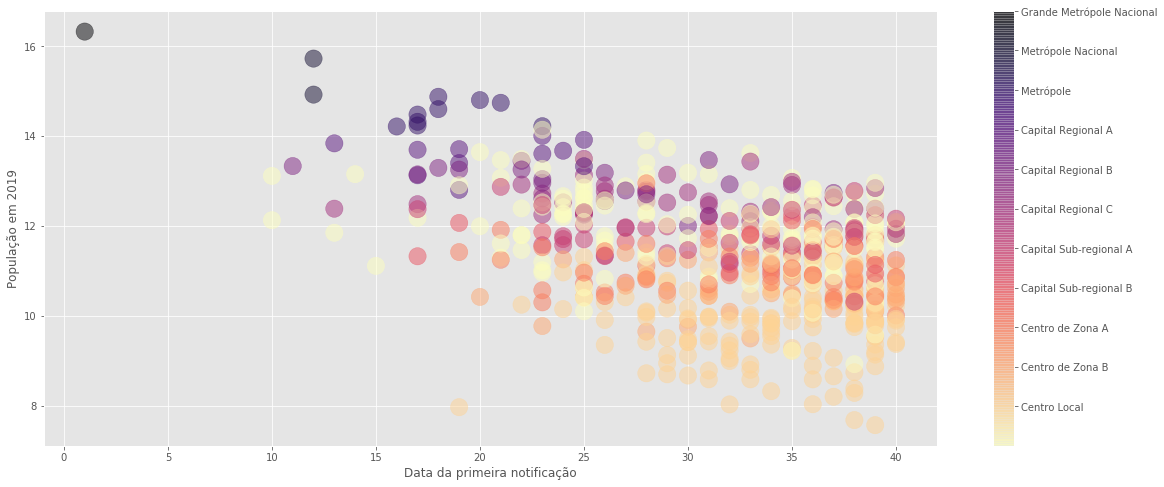

In [45]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,8))

color_map = plt.cm.get_cmap('magma')
color_map = color_map.reversed()

plt.scatter(c=df_fatores_geograficos['hierarquia'][filtro_dias], 
            x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias],
            y=np.log(df_fatores_geograficos.pop2019[filtro_dias]),
            alpha=0.5,
            cmap=color_map,
            s=300);


teste = plt.colorbar(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  11])
# teste.set_label('Hierarquia Urbana', rotation=270)
teste.ax.set_yticklabels(['Centro Local', 'Centro de Zona B', 'Centro de Zona A', 'Capital Sub-regional B', 'Capital Sub-regional A', 'Capital Regional C', 'Capital Regional B', 'Capital Regional A', 'Metrópole', 'Metrópole Nacional', 'Grande Metrópole Nacional'])  # horizontal colorbar

plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('Data da primeira notificação')
plt.ylabel('População em 2019');

In [ ]:
plt.legend?

In [ ]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

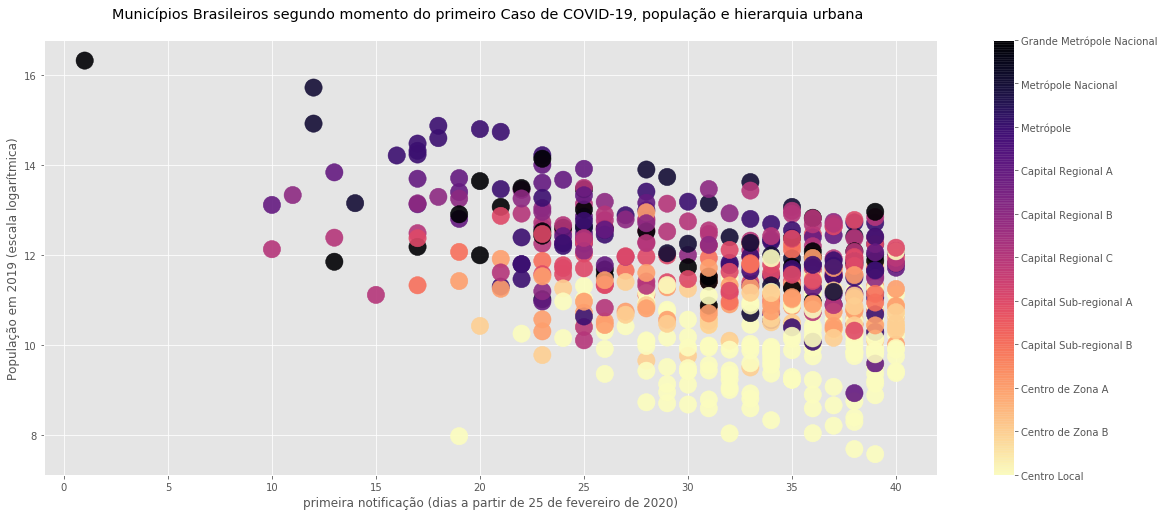

In [94]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,8))

color_map = plt.cm.get_cmap('magma')
color_map = color_map.reversed()

scatter = plt.scatter(c=df_fatores_geograficos['hierarquia'][filtro_dias], 
            x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias],
            y=np.log(df_fatores_geograficos.pop2019[filtro_dias]),
            alpha=0.9,
            cmap=color_map,
            s= 300);

ax.set_title('Municípios Brasileiros segundo momento do primeiro Caso de COVID-19, população e hierarquia urbana \n')
teste = plt.colorbar(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  11])
# teste.set_label('Hierarquia Urbana', rotation=270)
teste.ax.set_yticklabels(['Centro Local', 'Centro de Zona B', 'Centro de Zona A', 'Capital Sub-regional B', 'Capital Sub-regional A', 'Capital Regional C', 'Capital Regional B', 'Capital Regional A', 'Metrópole', 'Metrópole Nacional', 'Grande Metrópole Nacional'])  # horizontal colorbar

plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('primeira notificação (dias a partir de 25 de fevereiro de 2020)')
plt.ylabel('População em 2019 (escala logarítmica)');


plt.savefig('covid.png')
#lgnd = plt.legend(handles=handles, loc="lower left", scatterpoints=1)

#legend2 = ax.legend(handles, labels, loc="upper right", title="Sizes")
#lgnd.legendHandles[0]._sizes = [30]
#lgnd.legendHandles[1]._sizes = [30]

Para melhorar o gráfico acima, preciso pegar uns parâmetros nos links abaixo

https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html

https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D

https://matplotlib.org/3.1.0/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

https://stackoverflow.com/questions/11983024/matplotlib-legends-not-working

Minha intenção é colocar uma quarta variável (PIB) nesse mesmo gráfico

https://stackoverflow.com/questions/24706125/setting-a-fixed-size-for-points-in-legend

https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size

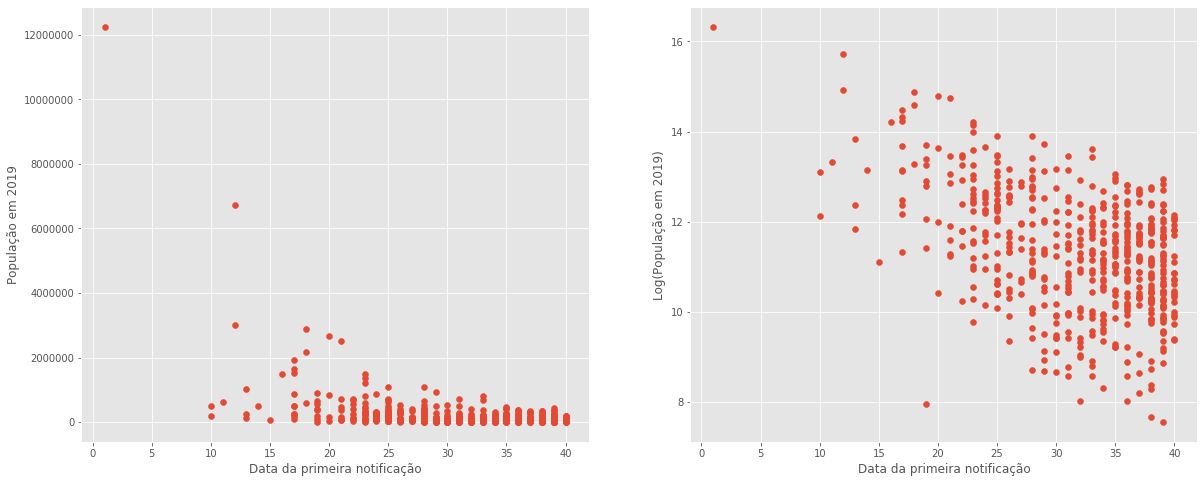

In [92]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pop2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('População em 2019')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pop2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(População em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
filtro_dias = df_fatores_geograficos.dias_contaminação_referencia >= 0

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))

ax[0].scatter(y=df_fatores_geograficos['pop2019'][filtro_dias], x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[0].set_ylabel('População em 2019')
ax[0].ticklabel_format(useOffset=False, style='plain')
ax[0].set_xlabel('Data da primeira notificação')
ax[0].set_ylabel('População em 2019')


ax[1].scatter(y=np.log(df_fatores_geograficos['pop2019'][filtro_dias]), x=df_fatores_geograficos.dias_contaminação_referencia[filtro_dias]);
ax[1].set_xlabel('Data da primeira notificação')
ax[1].set_ylabel('Log(População em 2019)')
ax[1].set_xlabel('Data da primeira notificação');

In [ ]:
fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(20,8))
ax

In [ ]:
fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(20,8))
ax[0,0].scatter(x=np.log(df_fatores_geograficos[variavel][df_fatores_geograficos.dias_contaminação_referencia.notna()]), y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,8))
ax[0].hist(df_fatores_geograficos.pop2019, bins=10)
ax[1].scatter(x=df_fatores_geograficos.pop2019[df_fatores_geograficos.dias_contaminação_referencia.notna()], y=df_fatores_geograficos.dias_contaminação_referencia[df_fatores_geograficos.dias_contaminação_referencia.notna()]);

In [ ]:
df_fatores_geograficos.pop2019

In [ ]:
df_fatores_geograficos.dia3103.max()

In [ ]:
df_fatores_geograficos.columns

In [ ]:
list_colunas_selecionadas = list(df_fatores_geograficos.columns[2:10])
list_colunas_selecionadas.append(df_fatores_geograficos.columns[-3])

In [ ]:
list_colunas_selecionadas

In [ ]:
df_fatores_geograficos_correlacao =  df_fatores_geograficos.loc[:, list_colunas_selecionadas]
df_fatores_geograficos_correlacao

In [ ]:
corr = df_fatores_geograficos_correlacao.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

In [ ]:
df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0]

In [ ]:
corr = df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap = sns.diverging_palette(250, 10, as_cmap=True))

In [ ]:
sns.pairplot(df_fatores_geograficos_correlacao)

In [ ]:
sns.pairplot(df_fatores_geograficos_correlacao[df_fatores_geograficos_correlacao.iloc[:,-1] != 0])

In [ ]:
corr

In [ ]:
df_fatores_geograficos['dia3103'].sum()

In [ ]:
df_fatores_geograficos_semzeros = df_fatores_geograficos[df_fatores_geograficos.iloc[:,-1] != 0]

In [ ]:
plt.scatter(df_fatores_geograficos['pop2019'], df_fatores_geograficos['dia2903'])

In [ ]:
plt.scatter(df_fatores_geograficos_correlacao_semzeros['pop2019'], df_fatores_geograficos_correlacao_semzeros['dia2903'])

In [ ]:
plt.scatter(df_fatores_geograficos_correlacao['pop2019'], df_fatores_geograficos_correlacao['dia2903'])

In [ ]:
plt.scatter(df_fatores_geograficos_correlacao['export_fob_2019'], df_fatores_geograficos_correlacao['dia2903'])

In [ ]:
sns.pairplot(df_fatores_geograficos_correlacao[['pop2019', 'dia2903']][df_fatores_geograficos_correlacao.iloc[:,-1] != 0], size=5)

In [ ]:
df_arranjos_populacionais